In [6]:
import torch
import numpy as np
import random
import string
import matplotlib.pyplot as plt
from tqdm import tqdm
import utils
import gen_data
from energies import Energies
from models import ConstrainedNet1D

## Load Image

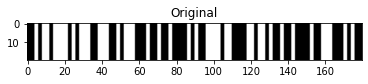

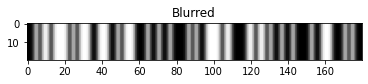

In [7]:
def get_barcode(name=None,val=1.5):
    if name == None:
        name = ''.join([random.choice(
                        string.ascii_letters + string.digits)
                        for n in range(5)])
    assert len(name)==5
    barcode, blurred = gen_data.load_barcode(name,val)
    h,w = barcode.shape
    barcode=barcode[h//2]
    blurred=blurred[h//2]
    return torch.tensor(barcode), torch.tensor(blurred)

bar,blur = get_barcode(val=1.0) # specify amount of blurring

plt.figure()
plt.imshow(utils.extend(bar),cmap="gray")
plt.title("Original")
plt.show()
plt.figure()
plt.imshow(utils.extend(blur),cmap="gray")
plt.title("Blurred")
plt.show()


## Prepare

In [8]:
device = "cuda"

# prepare images
Y = bar[None,None].float()
f = blur[None,None].float()
f = f.to(device)
Y = Y.to(device)
X = f.clone()

# setting
file = "./example/net_barcode_0_0.1_30.0_1_0.1.pt"
filevars = file.split('/')[-1]
vars = filevars.split('_')
alpha = float(vars[5])
mu = float(vars[6].split('.pt')[0])

# load network
network_onenorm = torch.load(file)
net1n = ConstrainedNet1D(in_chn = 3, out_chn = 1, zeta1 = network_onenorm.zeta1, zeta2 = network_onenorm.zeta2, \
                    features = 32, num_layers = 10, constrained=network_onenorm.constrained)
net1n.load_state_dict(network_onenorm.state_dict())
net1n.to(device)
net1n.eval()

# load energies and noise measurement
gradient = Energies.gradient_moreau_W(mu)
energy = Energies.moreau_W(mu)

## Optimize

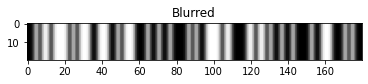

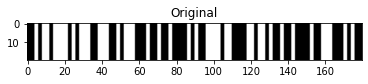

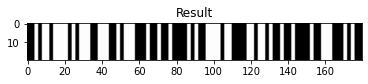

In [9]:
pbar = tqdm(range(40), disable=True)
results=[]
energies=[]
real_energies=[]
simil_img=[]

stepsize = net1n.zeta1 / ((net1n.zeta2**2)*(1/mu))
for i in pbar:

    # update step
    tau = np.maximum(1/(i+1)*2.2, stepsize)
    d_dir = -gradient(X)
    with torch.no_grad():
        d_dir = net1n(X, -d_dir, f)[0]
    X = X + tau * d_dir

    # save
    results.append(X.cpu())
    energies.append(energy(X).cpu())
    real_energies.append(Energies.energy_W(X).cpu())

# plot
plt.figure()
plt.title("Blurred")
plt.imshow(utils.extend(f[0,0].cpu()),cmap="gray")
plt.show()

plt.figure()
plt.title("Original")
plt.imshow(utils.extend(bar.cpu()),cmap="gray")
plt.show()

plt.figure()
plt.title("Result")
plt.imshow(utils.extend(results[-1][0,0]),cmap="gray")
plt.show()
